## Lab 2
### Part 2: Dealing with overfitting

Today we work with [Fashion-MNIST dataset](https://github.com/zalandoresearch/fashion-mnist) (*hint: it is available in `torchvision`*).

Your goal for today:
1. Train a FC (fully-connected) network that achieves >= 0.885 test accuracy.
2. Cause considerable overfitting by modifying the network (e.g. increasing the number of network parameters and/or layers) and demonstrate in in the appropriate way (e.g. plot loss and accurasy on train and validation set w.r.t. network complexity).
3. Try to deal with overfitting (at least partially) by using regularization techniques (Dropout/Batchnorm/...) and demonstrate the results.

__Please, write a small report describing your ideas, tries and achieved results in the end of this file.__

*Note*: Tasks 2 and 3 are interrelated, in task 3 your goal is to make the network from task 2 less prone to overfitting. Task 1 is independent from 2 and 3.

*Note 2*: We recomment to use Google Colab or other machine with GPU acceleration.

In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchsummary
from IPython.display import clear_output
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
import os
import time


device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [2]:
# Technical function
def mkdir(path):
    if not os.path.exists(root_path):
        os.mkdir(root_path)
        print('Directory', path, 'is created!')
    else:
        print('Directory', path, 'already exists!')
        
root_path = 'fmnist'
mkdir(root_path)

Directory fmnist is created!


In [3]:
download = True
train_transform = transforms.ToTensor()
test_transform = transforms.ToTensor()
transforms.Compose((transforms.ToTensor()))


fmnist_dataset_train = torchvision.datasets.FashionMNIST(root_path, 
                                                        train=True, 
                                                        transform=train_transform,
                                                        target_transform=None,
                                                        download=download)
fmnist_dataset_test = torchvision.datasets.FashionMNIST(root_path, 
                                                       train=False, 
                                                       transform=test_transform,
                                                       target_transform=None,
                                                       download=download)

Extracting fmnist/FashionMNIST/raw/train-images-idx3-ubyte.gz to fmnist/FashionMNIST/raw


Extracting fmnist/FashionMNIST/raw/train-labels-idx1-ubyte.gz to fmnist/FashionMNIST/raw


Extracting fmnist/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to fmnist/FashionMNIST/raw


Extracting fmnist/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to fmnist/FashionMNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [6]:
train_loader = torch.utils.data.DataLoader(fmnist_dataset_train, 
                                           batch_size=128,
                                           shuffle=True,
                                           num_workers=2)
test_loader = torch.utils.data.DataLoader(fmnist_dataset_test,
                                          batch_size=256,
                                          shuffle=False,
                                          num_workers=2)

In [7]:
fmnist_dataset_train_new = [fmnist_dataset_train[i] for i in range(len(fmnist_dataset_train)) if i <= 1000]

In [8]:
train_loader_for_overfit = torch.utils.data.DataLoader(fmnist_dataset_train_new, 
                                           batch_size=128,
                                           shuffle=True,
                                           num_workers=2)

In [9]:
print(len(fmnist_dataset_test))

10000


In [10]:
for img, label in train_loader:
    print(img.shape)
#     print(img)
    print(label.shape)
    print(label.size(0))
    break

torch.Size([128, 1, 28, 28])
torch.Size([128])
128


### Task 1
Train a network that achieves $\geq 0.885$ test accuracy. It's fine to use only Linear (`nn.Linear`) layers and activations/dropout/batchnorm. Convolutional layers might be a great use, but we will meet them a bit later.

In [11]:
class TinyNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            # Your network structure comes here
            nn.Linear(input_shape, 300),
            nn.LeakyReLU(),
            nn.Linear(300,200),
            nn.LeakyReLU(),
            nn.Linear(200,100),
            nn.LeakyReLU(),
            nn.Linear(100,10),
            nn.LeakyReLU(),
            nn.Linear(10,num_classes),           
        )
        
    def forward(self, inp):       
        out = self.model(inp)
        return out

In [12]:
torchsummary.summary(TinyNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 300]         235,500
         LeakyReLU-3                  [-1, 300]               0
            Linear-4                  [-1, 200]          60,200
         LeakyReLU-5                  [-1, 200]               0
            Linear-6                  [-1, 100]          20,100
         LeakyReLU-7                  [-1, 100]               0
            Linear-8                   [-1, 10]           1,010
         LeakyReLU-9                   [-1, 10]               0
           Linear-10                   [-1, 10]             110
Total params: 316,920
Trainable params: 316,920
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 1.21
Estimated T

Your experiments come here:

In [13]:
model = TinyNeuralNetwork().to(device)
opt = torch.optim.Adam(model.parameters())
loss_func = nn.CrossEntropyLoss()

# Your experiments, training and validation loops here 

In [14]:
def train_model(model, train_loader, val_loader, loss_fn, opt, n_epochs: int, device=device):
    train_loss = []
    val_loss = []
    val_accuracy = []
    
    for epoch in range(n_epochs):
        ep_train_loss = []
        ep_val_loss = []
        ep_val_accuracy = []
        start_time = time.time()

        model.train(True)
        for X_batch, y_batch in train_loader:
            opt.zero_grad()
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
       
            out = model(X_batch)
            loss = loss_fn(out, y_batch)
            loss.backward()
            opt.step()
            ep_train_loss.append(loss.item())

        model.train(False) 
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                
                out = model(X_batch)
                loss = loss_fn(out, y_batch)


             
                ep_val_loss.append(loss.item())
                y_pred = out.max(dim=1)[1]
                ep_val_accuracy.append(np.sum(y_batch.cpu().numpy() == y_pred.cpu().numpy().astype(float))/ len(y_batch.cpu()))
        print(f'Epoch {epoch + 1} of {n_epochs} took {time.time() - start_time:.3f}s')

        train_loss.append(np.mean(ep_train_loss))
        val_loss.append(np.mean(ep_val_loss))
        val_accuracy.append(np.mean(ep_val_accuracy))

        print(f"\t  training loss: {train_loss[-1]:.6f}")
        print(f"\tvalidation loss: {val_loss[-1]:.6f}")
        print(f"\tvalidation accuracy: {val_accuracy[-1]:.3f}")
    return train_loss, val_loss, val_accuracy

In [15]:
n_epochs = 15
train_loss, val_loss, val_accuracy = train_model(model, train_loader, test_loader, loss_func, opt, n_epochs)

Epoch 1 of 15 took 6.558s
	  training loss: 0.698693
	validation loss: 0.467463
	validation accuracy: 0.834
Epoch 2 of 15 took 6.458s
	  training loss: 0.415820
	validation loss: 0.413580
	validation accuracy: 0.852
Epoch 3 of 15 took 6.411s
	  training loss: 0.356835
	validation loss: 0.386077
	validation accuracy: 0.861
Epoch 4 of 15 took 6.382s
	  training loss: 0.328052
	validation loss: 0.356237
	validation accuracy: 0.869
Epoch 5 of 15 took 6.376s
	  training loss: 0.306063
	validation loss: 0.348423
	validation accuracy: 0.877
Epoch 6 of 15 took 6.296s
	  training loss: 0.288496
	validation loss: 0.343639
	validation accuracy: 0.877
Epoch 7 of 15 took 6.343s
	  training loss: 0.277536
	validation loss: 0.356854
	validation accuracy: 0.874
Epoch 8 of 15 took 6.353s
	  training loss: 0.267392
	validation loss: 0.343734
	validation accuracy: 0.875
Epoch 9 of 15 took 6.415s
	  training loss: 0.253050
	validation loss: 0.331136
	validation accuracy: 0.884
Epoch 10 of 15 took 6.346s
	

In [16]:
def plot_train_process(train_loss, val_loss, val_accuracy):
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    axes[0].set_title('Loss')
    axes[0].plot(train_loss, label='train')
    axes[0].plot(val_loss, label='validation')
    axes[0].legend()

    axes[1].set_title('Validation accuracy')
    axes[1].plot(val_accuracy)

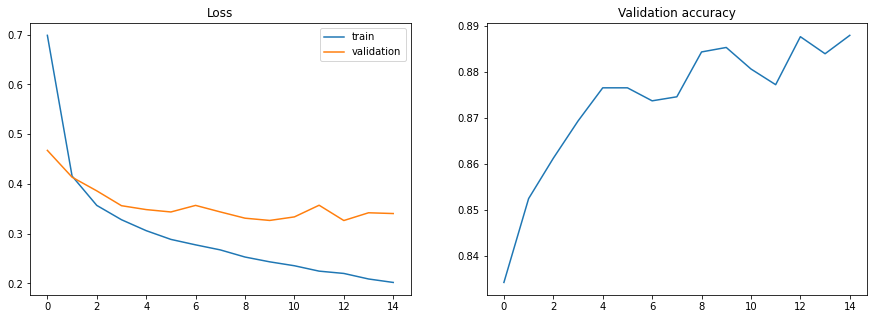

In [17]:
plot_train_process(train_loss, val_loss, val_accuracy)

### Task 2: Overfit it.
Build a network that will overfit to this dataset. Demonstrate the overfitting in the appropriate way (e.g. plot loss and accurasy on train and test set w.r.t. network complexity).

*Note:* you also might decrease the size of `train` dataset to enforce the overfitting and speed up the computations.

In [20]:
class OverfittingNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            # Your network structure comes here
            nn.Linear(input_shape, 700),
            nn.LeakyReLU(),
            nn.Linear(100, 200),
            nn.LeakyReLU(),
            nn.Linear(200, 300),
            nn.Sigmoid(),
            nn.Linear(300, 200),
            nn.LeakyReLU(),
            nn.Linear(200, 100),
            nn.LeakyReLU(),
            nn.Linear(100, 10),
            nn.LeakyReLU(),
            nn.Linear(10,num_classes),
        )
        
    def forward(self, inp):       
        out = self.model(inp)
        return out

In [21]:
torchsummary.summary(OverfittingNeuralNetwork().to(device), (28*28,))

RuntimeError: ignored

In [22]:
model = OverfittingNeuralNetwork().to(device)
opt = torch.optim.Adam(model.parameters())
loss_func = nn.CrossEntropyLoss()

# Your experiments, come here
n_epochs = 50
train_loss, val_loss, val_accuracy = train_model(model, train_loader_for_overfit, test_loader, loss_func, opt, n_epochs)

RuntimeError: ignored

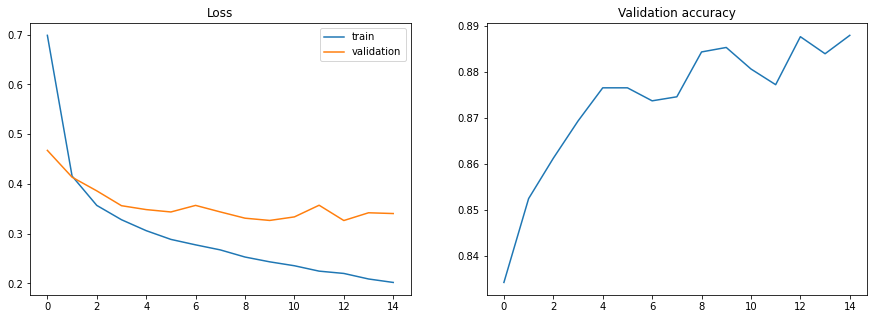

In [23]:
plot_train_process(train_loss, val_loss, val_accuracy)

### Task 3: Fix it.
Fix the overfitted network from the previous step (at least partially) by using regularization techniques (Dropout/Batchnorm/...) and demonstrate the results. 

In [24]:
class FixedNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            # Your network structure comes here
            nn.Linear(input_shape, 200),
            nn.BatchNorm1d(200),
            nn.LeakyReLU(),
            nn.Dropout(p=0.7),
            nn.Linear(200, 400),
            nn.BatchNorm1d(400),
            nn.LeakyReLU(),
            nn.Dropout(),
            nn.Linear(400, 600),
            nn.BatchNorm1d(600),
            nn.LeakyReLU(),
            nn.Dropout(),
            nn.Linear(600, 400),
            nn.BatchNorm1d(400),
            nn.LeakyReLU(),
            nn.Dropout(),
             nn.Linear(400, 200),
            nn.BatchNorm1d(200),
            nn.LeakyReLU(),
            nn.Dropout(),
            nn.Linear(200, 100),
            nn.BatchNorm1d(100),
            nn.LeakyReLU(),
            nn.Dropout(),
            nn.Linear(100, 10),
            nn.BatchNorm1d(10),
            nn.LeakyReLU(),
            nn.Dropout(),
            nn.Linear(10, num_classes)
        )
        
    def forward(self, inp):       
        out = self.model(inp)
        return out

In [25]:
torchsummary.summary(FixedNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 200]         157,000
       BatchNorm1d-3                  [-1, 200]             400
         LeakyReLU-4                  [-1, 200]               0
           Dropout-5                  [-1, 200]               0
            Linear-6                  [-1, 400]          80,400
       BatchNorm1d-7                  [-1, 400]             800
         LeakyReLU-8                  [-1, 400]               0
           Dropout-9                  [-1, 400]               0
           Linear-10                  [-1, 600]         240,600
      BatchNorm1d-11                  [-1, 600]           1,200
        LeakyReLU-12                  [-1, 600]               0
          Dropout-13                  [-1, 600]               0
           Linear-14                  [

In [26]:
model = OverfittingNeuralNetwork().to(device)
opt = torch.optim.Adam(model.parameters())
loss_func = nn.CrossEntropyLoss()

# Your experiments, come here
n_epochs = 50
train_loss, val_loss, val_accuracy = train_model(model, train_loader_for_overfit, test_loader, loss_func, opt, n_epochs)

RuntimeError: ignored

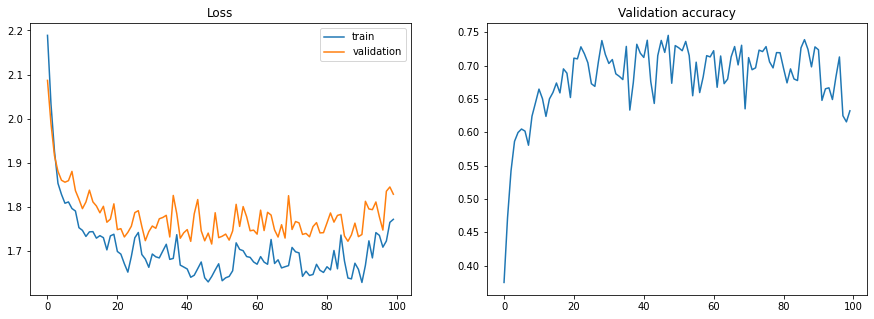

In [ ]:
plot_train_process(train_loss, val_loss, val_accuracy)

### Conclusions:
_Write down small report with your conclusions and your ideas._